# MFCCs Convolutional Neural Network

Below we build and assess a convolutional neural network that uses the MFCC image data to predict the sound class: cough, laughter, sigh, sneeze, sniff, and throat clear.

An important note is that this code was run on [kaggle](kaggle.com) to use its public GPU. This means the directories in which this notebook pulls from and saves to are specific to kaggle. If you run this notebook on your local machine use the paths to the `mfccs.npy` and `speaker_data_and_target.csv` that were generated in the previous notebook.

---

## Imports and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2

---

## Train-Val-Test Split

First let us load in our MFCC numpy array and the label data.

The label the `sound` is contained in the `speaker_data` dataframe, alongside information about each contributor to the audio dataset. Aside from the labels, `speaker_data` contains the sex, age, country, and language of the contributor. This will be interesting to look into later and see if these factors seem to impact the our model's performance.

In [2]:
# directories are through Kaggle, update these paths to where you placed the mfccs and speaker_data_and_target.csv
# that were generated in the previous notebook
mfccs = np.load('../input/mfcc-data/mfccs.npy')
speaker_data = pd.read_csv('../input/speaker-data-and-target/speaker_data_and_target.csv')

In [3]:
speaker_data.head()

,id,sound,sex,age,country,language
0,f0003,0,female,56,United States of America,EN
1,f0003,1,female,56,United States of America,EN
2,f0003,2,female,56,United States of America,EN
3,f0003,3,female,56,United States of America,EN
4,f0003,4,female,56,United States of America,EN


A necessary step for preprocessing our MFCC image data is we need an axis depicting the pixel values should be read as greyscale. We can accomplish this with `np.newaxis`.

In [4]:
# append 1 to the mfcc data shape (# of files, # of mfccs, # of frames, 1)
X = mfccs[..., np.newaxis]
y = speaker_data['sound']

Next we split our dataset into a training, validation, and test set. The validation data will be used to just our model across each epoch and make adjustments to the architecture of the neural network. The testing set will serve as genuinely unseen data.

In [5]:
# separate out a test set from our data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size = 0.15,
                                                            stratify = y,
                                                            random_state = 42)

In [6]:
# separate the not testing data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                 test_size = 0.15,
                                                 stratify = y_train_val,
                                                 random_state = 42)

---

## CNN

After several refinements, the architecture below led to one of our better performing models. This model contains several convolutional, max pooling, and dense layers. There is also some regularization in the form of Dropout and L2 regularization. Batch normalization is included for training efficiency.

In [7]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size= (3,3),
                 activation = 'relu', padding = 'same',
                 input_shape = (20,259,1), kernel_regularizer= l2(0.001)))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size= (3,3), activation = 'relu', padding = 'same', kernel_regularizer= l2(0.001)))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size= (3,3), activation = 'relu', padding = 'same', kernel_regularizer= l2(0.001)))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(32, activation = 'relu', kernel_regularizer= l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(32, activation = 'relu', kernel_regularizer= l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(32, activation = 'relu', kernel_regularizer= l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(6, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

2022-11-14 20:52:33.094635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 20:52:33.213243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 20:52:33.214021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 20:52:33.215949: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val))

2022-11-14 20:52:36.634413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-11-14 20:52:38.439397: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


474/474 [==============================] - 11s 7ms/step - loss: 1.8601 - accuracy: 0.2613 - val_loss: 1.6868 - val_accuracy: 0.3457
Epoch 2/30
474/474 [==============================] - 3s 6ms/step - loss: 1.4670 - accuracy: 0.4585 - val_loss: 1.1436 - val_accuracy: 0.6200
Epoch 3/30
474/474 [==============================] - 3s 6ms/step - loss: 1.1360 - accuracy: 0.6343 - val_loss: 0.9049 - val_accuracy: 0.7354
Epoch 4/30
474/474 [==============================] - 3s 6ms/step - loss: 0.9444 - accuracy: 0.7370 - val_loss: 0.8159 - val_accuracy: 0.7881
Epoch 5/30
474/474 [==============================] - 3s 6ms/step - loss: 0.8523 - accuracy: 0.7817 - val_loss: 0.7213 - val_accuracy: 0.8176
Epoch 6/30
474/474 [==============================] - 3s 6ms/step - loss: 0.7980 - accuracy: 0.8049 - val_loss: 0.6632 - val_accuracy: 0.8371
Epoch 7/30
474/474 [==============================] - 3s 6ms/step - loss: 0.7603 - accuracy: 0.8188 - val_loss: 0.6858 - val_accuracy: 0.8386
Epoch 8/30
474/4

## Assessing the Model

First we plot the model's performance history across each epoch during training. We check both loss and accuracy on the training and validation sets.

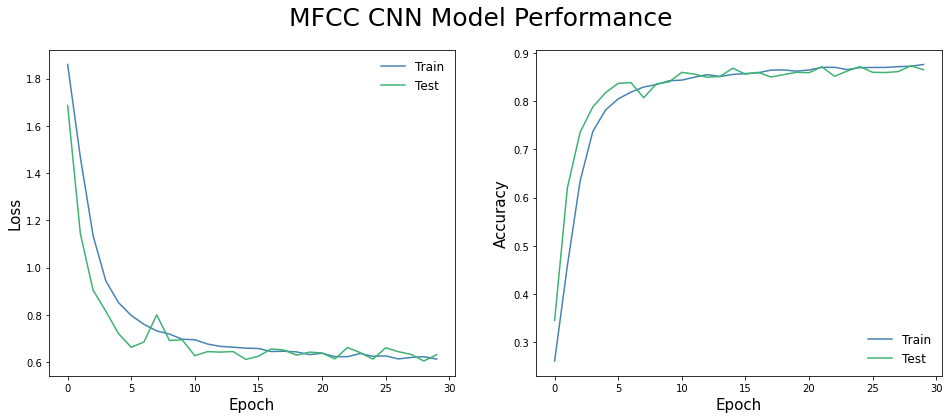

In [10]:
plt.figure(figsize = (16,6))

plt.suptitle('MFCC CNN Model Performance', size = 25)

plt.subplot(1,2,1)
#plt.title('Loss', size = 25)
plt.xlabel('Epoch', size = 15)
plt.ylabel('Loss', size = 15)
plt.plot(history.history['loss'], color = 'steelblue', label = 'Train')
plt.plot(history.history['val_loss'], color = 'mediumseagreen', label = 'Test')
plt.legend(fontsize = 'large', frameon = False)

plt.subplot(1,2,2)
#plt.title('Accuracy', size = 25)
plt.xlabel('Epoch', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.plot(history.history['accuracy'], color = 'steelblue', label = 'Train')
plt.plot(history.history['val_accuracy'], color = 'mediumseagreen', label = 'Test')
plt.legend(fontsize = 'large', frameon = False)

plt.savefig('mfcc_cnn.jpg');

The train and test graphs hug each other very cosely and suggest the model is not overfit.

Let us now look at the quality of the predictions on test data set. Our model predictions come in the form of probabilities, so we need to use `np.argmax()` to extract the index with the largest probability. This will be the label prediction. It will be interesting to examine when the model was confident or not, so we will also store the probability the model assigned to its prediction.

In [11]:
# model's expected probability of each sound category
test_probs = model.predict(X_test)

# model's prediction (index with the highest probability value)
test_preds = np.argmax(test_probs, axis = 1)

# model's expected probability of correct prediction
test_confidence = test_probs.max(axis = 1)

In [12]:
print('Accuracy:', accuracy_score(y_test, test_preds))
print('Recall:', recall_score(y_test, test_preds, average = None))
print('Precision:', precision_score(y_test, test_preds, average = None))
print('F1:', f1_score(y_test, test_preds, average = None))

Accuracy: 0.8672172808132147
Recall: [0.90285714 0.9047619  0.86666667 0.86641221 0.90285714 0.75954198]
Precision: [0.76823339 0.92592593 0.86337761 0.90258449 0.89265537 0.87089716]
F1: [0.83012259 0.91522158 0.86501901 0.88412853 0.89772727 0.81141692]


The lists above represent scores for cough, laughter, sigh, sneeze, sniff, and throat clearing, respectively.

The recall score is strongest with coughs, laughter, and sniffs, and poorest with throatclearing. This means that the model does not label the first group as anything else very often but will frequently label throatclears as something else (likely a cough). Below we have plotted a confusion matrix and we can see that the model makes the most errors deciding between coughs and throat clears, oftentimes classifying a throat clear as a cough.

The precision scores are generally quite except for coughs. This makes sense with are previous analysis that throat clears are often classified incorrectly as coughs. In other words, cough classifications are a bit less precise.

Our F1 scores are a balance of recall and precision. Unsurprisingly, we see the highest F1 scores alongside laughs and sniffs. Our lowest value occurs with throat clears.

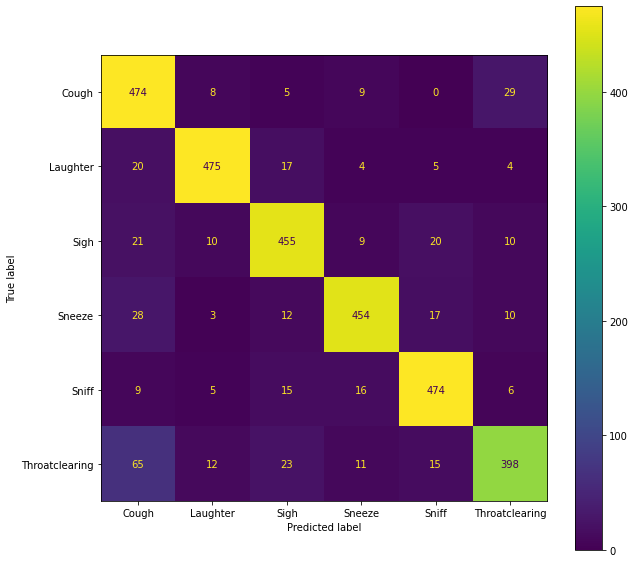

In [13]:
sound_label = ['Cough', 'Laughter', 'Sigh', 'Sneeze', 'Sniff', 'Throatclearing']

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, ax = ax, display_labels = sound_label)
plt.savefig('mfcc_confusion_matric.jpg');

## Saving The Model and Prediction Data

Keras offers a method for saving neural networks for later use. Let us save our model to be used later in a `Streamlit` application.

In [14]:
model.save('mfcc_model.h5')

There is some more potential for analysis with the prediction, confidence, and speaker data. Let us combine these all into one dataframe and save it to explore in another notebook.

In [15]:
test_indices = y_test.index
test_speaker_data = speaker_data.loc[test_indices]

In [16]:
test_speaker_data['pred'] = test_preds
test_speaker_data['confidence'] = test_confidence
test_speaker_data.head()

,id,sound,sex,age,country,language,pred,confidence
4657,f1618,0,female,33,United States of America,EN,0,0.999987
20733,m3306,0,male,32,United States of America,EN,0,0.996304
16986,m2271,1,male,25,India,TA,1,0.745164
14919,m1678,4,male,20,Brazil,PT,4,0.999747
19525,m2954,4,male,23,Brazil,PT,4,0.959576


Let us save this test set prediction data so we can perform analysis on it in a later notebook.

In [18]:
test_speaker_data.to_csv('test_speaker_data.csv', index = False)

In [97]:
incorrect_pred = speaker_data_test[speaker_data_test['sound'] != speaker_data_test['pred']]
correct_pred = speaker_data_test[speaker_data_test['sound'] == speaker_data_test['pred']]

incorrect_pred

,id,sound,sex,age,country,language,pred,confidence
16986,m2271,1,male,25,India,TA,2,0.678301
16346,m2089,3,male,38,Canada,EN,0,0.367634
14811,m1632,4,male,31,India,HI,2,0.794224
17853,m2507,0,male,43,Brazil,PT,2,0.487990
7155,f2522,2,female,47,United States of America,ZH,3,0.338817
...,...,...,...,...,...,...,...,...
15707,m1926,0,male,64,United States of America,TA,1,0.818769
3466,f1238,3,female,26,United States of America,ES,2,0.988301
12280,m0829,5,male,23,United Kingdom,EN,4,0.686044
16390,m2103,5,male,35,India,EN,3,0.397201


In [133]:
# convert to bar chart clumped by male/female/other on x_axis and with legend/color as correct, incorrect

In [95]:
speaker_data_test['sex'].value_counts(normalize = True)

 male      0.547967
 female    0.448221
 other     0.003812
Name: sex, dtype: float64

In [98]:
correct_pred['sex'].value_counts(normalize = True)

 male      0.548517
 female    0.447455
 other     0.004028
Name: sex, dtype: float64

In [96]:
incorrect_pred['sex'].value_counts(normalize = True)

 male      0.544365
 female    0.453237
 other     0.002398
Name: sex, dtype: float64

In [102]:
speaker_data_test

,id,sound,sex,age,country,language,pred,confidence
4657,f1618,0,female,33,United States of America,EN,0,0.999961
20733,m3306,0,male,32,United States of America,EN,0,0.995873
16986,m2271,1,male,25,India,TA,2,0.678301
14919,m1678,4,male,20,Brazil,PT,4,0.998928
19525,m2954,4,male,23,Brazil,PT,4,0.903381
...,...,...,...,...,...,...,...,...
17859,m2509,0,male,27,India,EN,0,0.993554
15142,m1753,5,male,19,United States of America,EN,5,0.964370
11434,m0573,5,male,31,United States of America,EN,5,0.845415
788,f0330,4,female,38,India,TA,5,0.404087


In [124]:
speaker_data_test['language'].value_counts(normalize = True).round(2).head(5)

 EN    0.67
 PT    0.08
 IT    0.06
 TA    0.04
 HI    0.03
Name: language, dtype: float64

In [131]:
correct_pred['language'].value_counts(normalize = True).round(2).head(10)

 EN    0.69
 PT    0.08
 IT    0.06
 TA    0.03
 ES    0.02
 HI    0.02
 ML    0.02
 TE    0.01
 FR    0.01
 DE    0.00
Name: language, dtype: float64

In [130]:
incorrect_pred['language'].value_counts(normalize = True).round(2).head(5)

 EN    0.59
 PT    0.09
 TA    0.07
 IT    0.06
 HI    0.06
Name: language, dtype: float64

It does not appear that sex have much influence on whether or not the model performs well. It is hard to say if language has much impact. The language class is very imbalanced and the number of incorrect predictions on the test set is small (417 entries). English does makes up a notably smaller percentage of the incorrect predictions. It also appears that the languages Tamil (`TA`) and Hindi (`HI`) have more representation in the incorrect predictions set than the correct predictions set.

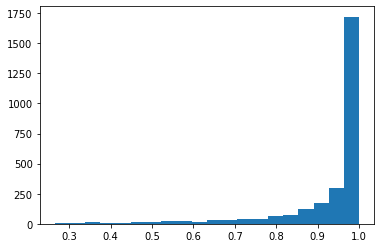

In [151]:
plt.hist(correct_pred['confidence'], bins = 20);

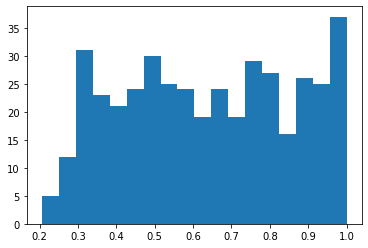

In [174]:
plt.hist(incorrect_pred['confidence'], bins = 18);

The histrogram of confidence levels for correct predictions is very left skewed. When the model gets the predictions correct, it seems to generally be very confident. On the other hand, the histogram of confidence levels for incorrect predictions appears fairly uniform. When the model makes an incorrect prediction, its confidence levels are all over the place.

In [176]:
speaker_data_test.groupby('sound')[['confidence']].mean()

,confidence
sound,
0,0.916048
1,0.900536
2,0.898440
3,0.894100
4,0.898593
5,0.831256


In [177]:
correct_pred.groupby('sound')[['confidence']].mean()

,confidence
sound,
0,0.934041
1,0.947195
2,0.936751
3,0.938627
4,0.931229
5,0.876081


In [178]:
correct_pred.groupby('sound')[['confidence']].mean()
incorrect_pred.groupby('sound')[['confidence']].mean()

,confidence
sound,
0,0.671642
1,0.545619
2,0.607027
3,0.650581
4,0.640827
5,0.678700


In [179]:
incorrect_pred.groupby('sound')[['confidence']].median()

,confidence
sound,
0,0.656654
1,0.510961
2,0.536106
3,0.660046
4,0.659335
5,0.693387
